### Exercise 20

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm_notebook
import time

**Trainning data**

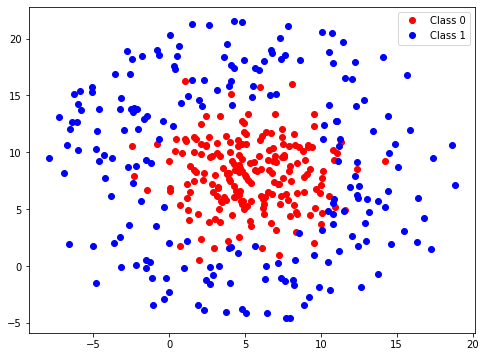

In [2]:
# Synthetic data
m_= 200
mu = np.array([5,8])
sigma = np.array([[10,0],[0,10]])
X1 = np.random.multivariate_normal(mu,sigma,m_)

phi = np.random.uniform(0,2*np.pi,m_).reshape(-1,1)
r = 6 + np.random.uniform(0,8,m_).reshape(-1,1)
X2 = np.concatenate((r*np.cos(phi)+mu[0],r*np.sin(phi)+mu[1]),1)

plt.figure(figsize=(8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label = 'Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label = 'Class 1')
plt.legend()
plt.show()

X = np.concatenate((X1,X2),0)
y = np.concatenate((np.ones((m_,1)),np.zeros((m_,1))),0)

In [3]:
#Split data into train set and validation set
def train_val_split(X,y,train_size):
    m = X.shape[0]
    order = np.arange(m)
    np.random.shuffle(order)
    train_len = int(m*train_size)
    train_in = order[:train_len]
    val_in = order[train_len:]
    X_train = X[train_in,:]
    y_train = y[train_in,:]
    X_val = X[val_in,:]
    y_val = y[val_in,:]
    return X_train,y_train,X_val,y_val
X_train,y_train,X_val,y_val = train_val_split(X,y,0.8)
X_train.shape,y_train.shape,X_val.shape,y_val.shape

((320, 2), (320, 1), (80, 2), (80, 1))

**Neural Network architecture**

<div> <img src="Neural Network.png" alt="Neural Network" style="width: 600px;"/></div>

**Data structure needed:** **L**: hidden layer; **n**: input features; **$m^{[j]}$**: unit in layer j
- Weight: $\mathtt{W}$
$$\mathtt{W}^{[j]} = \underbrace{\begin{vmatrix}w_{11} & w_{12} & .. & w_{1n} \\ w_{21} & w_{22} & .. & w_{2n} \\ : & : & .. & : \\ w_{m1} & w_{m2} & .. & w_{mn} \end{vmatrix}}_{\text{hidden_unit} \times \text{input_feature}}
$$

- Bias: $\mathtt{b}$
$$\mathtt{b}^{[j]} = \underbrace{\begin{vmatrix}b_{1} \\ b_{2} \\ : \\ b_{m} \end{vmatrix}}_{\text{hidden_unit} \times 1}
$$

- Activation functions $\mathtt{g}(z)$
- $\mathtt{z}$ is the linear response  $\mathtt{z} = \mathtt{w}^{T}x + b$
- $\mathtt{a}$ is the output of the activation function of the $i^{th}$ unit in the $j^{th}$ layer: $\mathtt{a}^{[0]}_{i} = X_{i}$ , ...; $\mathtt{a}^{[1]}_{1} = g(z^{[1]}_{1})$ ...
- Delta: $$\delta^{[L]} = (\mathtt{a}^{[L]} - y); \delta^{[i-1]} = diag(\mathtt{g}^{'}(z^{[i-1]})).\mathtt{w}^{[i]T}.\delta^{[i]}$$

**Activation function**
- Sigmoid
$$\mathtt{g}(z) = \frac{1}{1 + e^{-z}} ; \quad
\hat y = \begin{cases}
0 & \quad \text{if $\mathtt{g}(z) \leq 0.5$} \\ 
1 & \quad \text{otherwise}
\end{cases}$$

- ReLu

$$\mathtt{g}(z) = \max(z,0); \quad
\hat y = \begin{cases}
z & \quad \text{if $\mathtt{g}(z) \geq 0$} \\ 
0 & \quad \text{otherwise}
\end{cases}$$

- Hyperbolic tangent (TANH)
- Softmax

**Assume model**

Let's try a model consisting of the two inputs ($x_1$ and $x_2$), two hidden layers,
and an output layer. Let's use 4 units in layer 1 and 3 units in layer 2. Since layer
3 is the output layer and we have a binary classification problem, the output layer will
have just one sigmoid unit. We'll use ReLU for the hidden layers.

Layer 0: 2 inputs feature $x_1$ and $x_2$

layer 1: 4 units $\rightarrow$ output 4 features
- $\mathtt{W}^{[1]}: 4x2$
- $\mathbf{b}^{[1]}: 4x1$

layer 2: 3 units $\rightarrow$ output 3 features
- $\mathtt{W}^{[2]}: 3x4$
- $\mathbf{b}^{[2]}: 3x1$

layer 3: 1 units $\rightarrow$ output 1 result
- $\mathtt{W}^{[1]}: 1x3$
- $\mathbf{b}^{[1]}: 1x1$

**Initialize the weights**
- Small random normal values with mean 0
$$w^{[i]}_{jk} \sim \mathcal{N}(0,0.1)$$
- Xavier/He initialization
$$w^{[i]}_{jk} \sim \mathcal{N} \left( 0,\sqrt{\frac{2}{n^{[i]}+n^{[i-1]}}} \right) ; n^{[i]} \small 
\text{is the number of units in layer i}$$

In [4]:
#initial parameters
a = {}
z = {}
delta = {}

W = {}
W[1]=np.random.normal(0,0.1,(32,2))
W[2]=np.random.normal(0,0.1,(16,32))
W[3]=np.random.normal(0,0.1,(1,16))

b ={}
b[1]=np.zeros((32,1)) + 0.5
b[2]=np.zeros((16,1)) + 0.5
b[3]=np.zeros((1,1))

In [5]:
# define functions
def sigmoid(z):
    return 1/(1+np.exp(-z))

def sigmoid_der(z):
    a = sigmoid(z)
    return a*(1-a)

def relu(z):
    return np.where(z>0,z,0)

def relu_der(z):
    return np.where(z>0,1,0)

g ={}
g[1]=relu
g[2]=relu
g[3]=sigmoid

gprime ={}
gprime[1] =relu_der
gprime[2] =relu_der
gprime[3] =sigmoid_der

In [6]:
# Forward propagation
def forward(W,b,z,a,g,x):
    L = len(W)
    a[0] = x
    for l in range(1, L+1):
        z[l]=(W[l]@a[l-1])+b[l]
        a[l]=g[l](z[l])

# Backward propagation
def backward(W, a, z,delta,y,batch_size):
    L = len(W)
    dW = {}
    db = {}
    delta[L] = a[L] - y.T
    for l in range(L,0,-1):
        # Calculate gradient for weights
        dW[l]=delta[l]@a[l-1].T
        # Calculate gradient for biases
        db[l]=delta[l].mean(axis=1,keepdims=True)
        # Calculate previous layer's deltas
        if l>1:
            delta[l-1] = np.diag((gprime[l-1](z[l-1]).sum(axis=1,keepdims=True)/batch_size).reshape(-1))@W[l].T@delta[l]
    return dW,db
def update_weights(W,b,dW,db,alpha):
    L = len(W)
    for l in range(1, L+1):
        W[l] = W[l] - alpha *dW[l]
        b[l] = b[l] - alpha *db[l]

In [7]:
# Accuracy function
def accuracy(X,y,W,b,g):
    m = X.shape[0]
    a={}
    z={}
    sum = 0
    y_pred = []
    for i in range(m):
        x = X[i,:].reshape(-1,1)
        target = y[i,:].reshape(-1,1)
        forward(W,b,z,a,g,x)
        y_pred.append(np.where(a[L]>0.5,1.0,0.0))
        sum += np.where(a[L]>0.5,1.0,0.0) == target
    return sum[0,0]/m

# predict function
def predict(W,b,z,a,g,X):
    m = X.shape[0]
    a={}
    z={}
    results = np.zeros((m,1))
    for i in range(m):
        x = X[i,:].reshape(-1,1)
        forward(W,b,z,a,g,x)
        results[i] = a[L]
    return np.where(results>0.5,1.0,0.0)

In [8]:
m = X_train.shape[0]
m_val = X_val.shape[0]
batch_size = 4
n_batch = m//batch_size

epochs = 1000
alpha = 0.001
L = len(W)
train_loss_epoch = []
val_loss_epoch = []
for epoch in tqdm_notebook(range(epochs),desc = "Progress Bar"):
    time.sleep(0)
    index = np.arange(m)
    np.random.shuffle(index)
    iter_train_loss = 0
    iter_val_loss = 0
    # Traning loss
    for iter in range(n_batch):
        x_train = X_train[index[iter*batch_size:(iter+1)*batch_size],:].T
        target_train = y_train[index[iter*batch_size:(iter+1)*batch_size],0]
        forward(W,b,z,a,g,x_train)
        dW,db =  backward(W, a, z,delta,target_train,batch_size)
        update_weights(W,b,dW,db,alpha)
        train_loss = (- (target_train*np.log(a[L]) + (1- target_train)*np.log(1-a[L]))).sum() #cross entropy loss
        iter_train_loss+= train_loss
    train_loss_epoch.append(iter_train_loss/m)   
        
    # Validation loss
    for iter in range(m_val):
        x_val = X_val[iter*batch_size:(iter+1)*batch_size,:].T
        target_val = y_val[iter*batch_size:(iter+1)*batch_size,0]
        forward(W,b,z,a,g,x_val)
        val_loss = (- (target_val*np.log(a[L]) + (1- target_val)*np.log(1-a[L]))).sum() #cross entropy loss
        iter_val_loss+= val_loss
    val_loss_epoch.append(iter_val_loss/m_val)
    if epoch%100 ==0:
        print('Epoch %d Train loss %f Val loss %f' %(epoch,iter_train_loss/m,iter_val_loss/m_val))

Epoch 0 Train loss 0.694018 Val loss 0.699772
Epoch 100 Train loss 0.267599 Val loss 0.366854
Epoch 200 Train loss 0.241692 Val loss 0.339204
Epoch 300 Train loss 0.227728 Val loss 0.254559
Epoch 400 Train loss 0.232223 Val loss 0.254836
Epoch 500 Train loss 0.217907 Val loss 0.243027
Epoch 600 Train loss 0.220958 Val loss 0.223964
Epoch 700 Train loss 0.200273 Val loss 0.241030
Epoch 800 Train loss 0.203041 Val loss 0.223126
Epoch 900 Train loss 0.212194 Val loss 0.225188



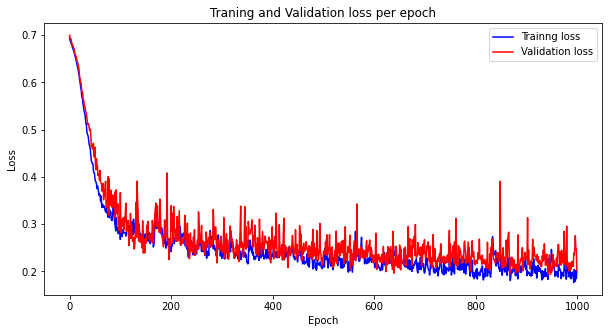

In [9]:
plt.figure(figsize = (10,5))
plt.plot(train_loss_epoch,'b-',label='Trainng loss')
plt.plot(val_loss_epoch,'r-',label='Validation loss')
plt.title('Traning and Validation loss per epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [10]:
acc_train = accuracy(X_train,y_train,W,b,g)
acc_val = accuracy(X_val,y_val,W,b,g)
print('Training Accuracy:',acc_train)
print('Validation Accuracy:',acc_val)

Training Accuracy: 0.915625
Validation Accuracy: 0.875


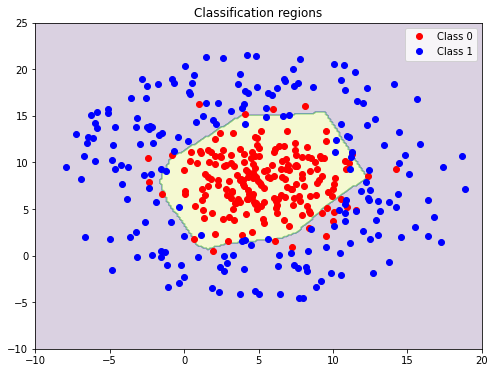

In [11]:
# Plot result
plt.figure(figsize = (8,6))
plt.plot(X1[:,0],X1[:,1],'ro',label='Class 0')
plt.plot(X2[:,0],X2[:,1],'bo',label='Class 1')

# Overlay colored regions
grid_x,grid_y = np.mgrid[-10:20:200j,-10:25:200j]
grid_xy = np.vstack([grid_x.ravel(),grid_y.ravel()]).T
z = predict(W,b,z,a,g,grid_xy).reshape((200,200))
plt.contourf(grid_x,grid_y,z,alpha = 0.2)


plt.title('Classification regions')
plt.legend()
plt.show()